In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        # Note: input dimension is 196 (14x14), not 784.
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)
        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training routine for an MLP
def train_mlp(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test_mlp(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    return correct / total

In [11]:
# --------------------------
# Dataset: Each MLP is represented as a graph (nodes = layers) with padded node features.
# --------------------------
class MLPGraphDatasetPadded(torch.utils.data.Dataset):
    def __init__(self, model_folder):
        self.model_paths = [os.path.join(model_folder, fname) 
                            for fname in os.listdir(model_folder) if fname.endswith('.pt')]
        self.max_feat_dim = self.compute_max_feat_dim()

    def compute_max_feat_dim(self):
        dims = []
        for path in self.model_paths:
            # Use weights_only=True to avoid potential pickle security warnings
            weights, biases = torch.load(path, weights_only=True)
            for w, b in zip(weights, biases):
                dims.append(w.numel() + b.numel())
        return max(dims)

    def __len__(self):
        return len(self.model_paths)

    def __getitem__(self, idx):
        weights, biases = torch.load(self.model_paths[idx], weights_only=True)
        features = []
        for w, b in zip(weights, biases):
            feat = torch.cat([w.flatten(), b.flatten()])
            pad_size = self.max_feat_dim - feat.numel()
            if pad_size > 0:
                feat = F.pad(feat, (0, pad_size))
            features.append(feat)
        # Stack features: shape [num_layers, max_feat_dim]
        x = torch.stack(features)
        num_nodes = x.size(0)
        # Build a simple chain graph for the MLP:
        # For 3 layers, we use bidirectional edges between consecutive nodes.
        row = list(range(num_nodes - 1)) + list(range(1, num_nodes))
        col = list(range(1, num_nodes)) + list(range(num_nodes - 1))
        edge_index = torch.tensor([row, col], dtype=torch.long)
        return Data(x=x, edge_index=edge_index)

# Create the dataset and PyG DataLoader
dataset = MLPGraphDatasetPadded("models")
graph_loader = DataLoader(dataset, batch_size=8, shuffle=True)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
from torch_geometric.nn import GCNConv

class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        z = self.conv2(x, edge_index)
        return z

class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_channels)
        )

    def forward(self, z):
        return self.fc(z)

class GraphAutoencoder(nn.Module):
    def __init__(self, node_feature_dim, latent_dim=64):
        super().__init__()
        self.encoder = GraphEncoder(node_feature_dim, 128, latent_dim)
        self.decoder = GraphDecoder(latent_dim, node_feature_dim)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_hat = self.decoder(z)
        return x_hat


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Get feature dimension from one sample
sample_data = dataset[0]
feature_dim = sample_data.x.shape[1]

model = GraphAutoencoder(node_feature_dim=feature_dim, latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def train_autoencoder(epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in graph_loader:
            batch = batch.to(device)  # batch is a Batch object from PyG
            optimizer.zero_grad()
            # Forward pass: note that batch.x is concatenated over graphs, and batch.edge_index is adjusted.
            x_hat = model(batch.x, batch.edge_index)
            loss = loss_fn(x_hat, batch.x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(graph_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Train the autoencoder
train_autoencoder(epochs=25)

Epoch 1/25, Loss: 0.0134
Epoch 2/25, Loss: 0.0122
Epoch 3/25, Loss: 0.0113
Epoch 4/25, Loss: 0.0110
Epoch 5/25, Loss: 0.0108
Epoch 6/25, Loss: 0.0107
Epoch 7/25, Loss: 0.0106
Epoch 8/25, Loss: 0.0106
Epoch 9/25, Loss: 0.0105
Epoch 10/25, Loss: 0.0104
Epoch 11/25, Loss: 0.0104
Epoch 12/25, Loss: 0.0103
Epoch 13/25, Loss: 0.0102
Epoch 14/25, Loss: 0.0101
Epoch 15/25, Loss: 0.0100
Epoch 16/25, Loss: 0.0098
Epoch 17/25, Loss: 0.0097
Epoch 18/25, Loss: 0.0095
Epoch 19/25, Loss: 0.0094
Epoch 20/25, Loss: 0.0092
Epoch 21/25, Loss: 0.0091
Epoch 22/25, Loss: 0.0089
Epoch 23/25, Loss: 0.0088
Epoch 24/25, Loss: 0.0085
Epoch 25/25, Loss: 0.0084


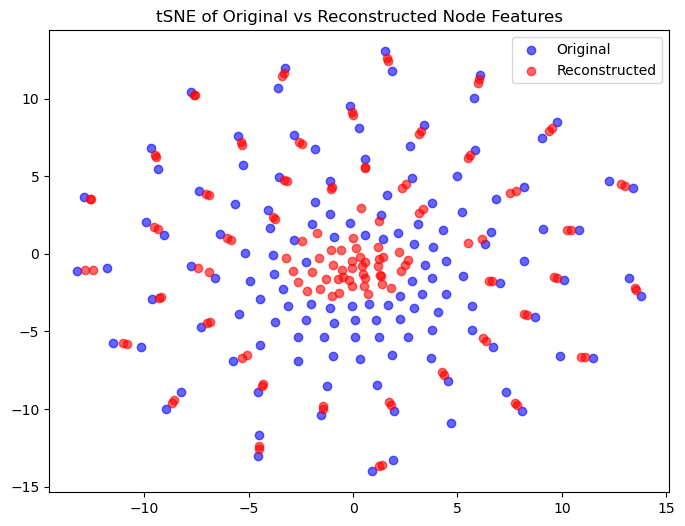

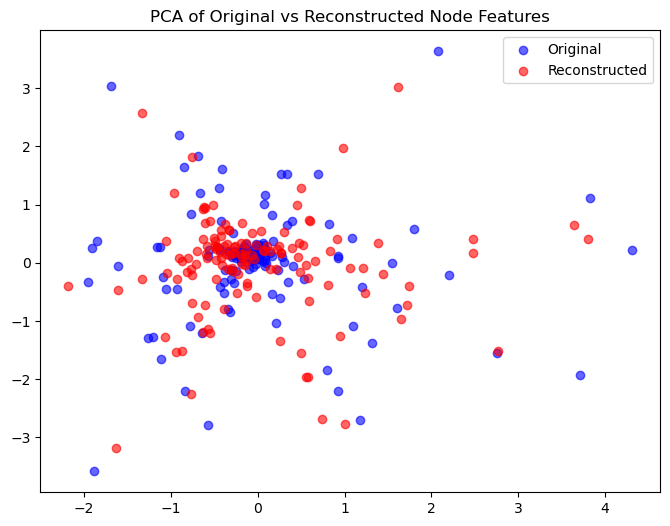

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def evaluate_autoencoder():
    model.eval()
    all_original = []
    all_recon = []
    with torch.no_grad():
        for batch in graph_loader:
            batch = batch.to(device)
            z = model.encoder(batch.x, batch.edge_index)
            x_recon = model.decoder(z)
            all_original.append(batch.x.cpu())
            all_recon.append(x_recon.cpu())
    all_original = torch.cat(all_original, dim=0)
    all_recon = torch.cat(all_recon, dim=0)
    
    # Use tSNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    combined = torch.cat([all_original, all_recon], dim=0)
    embedded = tsne.fit_transform(combined.numpy())
    num = all_original.size(0)
    plt.figure(figsize=(8,6))
    plt.scatter(embedded[:num,0], embedded[:num,1], c='blue', alpha=0.6, label='Original')
    plt.scatter(embedded[num:,0], embedded[num:,1], c='red', alpha=0.6, label='Reconstructed')
    plt.title("tSNE of Original vs Reconstructed Node Features")
    plt.legend()
    plt.show()
    
    # Similarly, use PCA
    pca = PCA(n_components=2)
    pca_embedded = pca.fit_transform(combined.numpy())
    plt.figure(figsize=(8,6))
    plt.scatter(pca_embedded[:num,0], pca_embedded[:num,1], c='blue', alpha=0.6, label='Original')
    plt.scatter(pca_embedded[num:,0], pca_embedded[num:,1], c='red', alpha=0.6, label='Reconstructed')
    plt.title("PCA of Original vs Reconstructed Node Features")
    plt.legend()
    plt.show()

evaluate_autoencoder()

In [19]:
def rebuild_mlp_from_graph(x_recon, max_feat_dim):
    """
    x_recon: Tensor of shape [num_layers, max_feat_dim] from the autoencoder reconstruction.
    For our MLP:
      - fc1: (32,196) weights and (32,) bias, total length = 32*196 + 32 = 6304.
      - fc2: (32,32) weights and (32,) bias, total length = 32*32 + 32 = 1056.
      - fc3: (10,32) weights and (10,) bias, total length = 10*32 + 10 = 330.
    """
    # Slice reconstructed vectors to true lengths:
    fc1_vec = x_recon[0, :6304]
    fc2_vec = x_recon[1, :1056]
    fc3_vec = x_recon[2, :330]
    
    # Reshape for fc1
    fc1_weight = fc1_vec[:32 * 196].reshape(32, 196)
    fc1_bias   = fc1_vec[32 * 196:].reshape(32)
    
    # Reshape for fc2
    fc2_weight = fc2_vec[:32 * 32].reshape(32, 32)
    fc2_bias   = fc2_vec[32 * 32:].reshape(32)
    
    # Reshape for fc3
    fc3_weight = fc3_vec[:10 * 32].reshape(10, 32)
    fc3_bias   = fc3_vec[10 * 32:].reshape(10)
    
    # IMPORTANT: Make sure that the new MLP is instantiated with input dimension 196.
    new_mlp = MLP()  # This constructor should create fc1 with nn.Linear(196, 32)
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp


In [21]:
# Assume MNIST test loader has been set up with downsampling to 14x14.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# For demonstration, we'll rebuild an MLP from one sample in our dataset.
# (In practice you might iterate over many samples and average performance.)
sample_data = dataset[0]  # get a single graph sample
sample_data = sample_data.to(device)
model.eval()
with torch.no_grad():
    # Pass through the autoencoder to get reconstructed node features.
    x_recon = model(sample_data.x, sample_data.edge_index)
    
# Rebuild MLP from the reconstructed node features.
reconstructed_mlp = rebuild_mlp_from_graph(x_recon.cpu(), dataset.max_feat_dim)
reconstructed_mlp.to(device)

# Load an original MLP for comparison.
# For this demonstration, we'll load the weights from the same file we used for the dataset.
weights, biases = torch.load(dataset.model_paths[0], weights_only=True)
def load_mlp_from_weights(weights, biases):
    original = MLP()
    with torch.no_grad():
        original.fc1.weight.copy_(weights[0])
        original.fc1.bias.copy_(biases[0])
        original.fc2.weight.copy_(weights[1])
        original.fc2.bias.copy_(biases[1])
        original.fc3.weight.copy_(weights[2])
        original.fc3.bias.copy_(biases[2])
    return original

original_mlp = load_mlp_from_weights(weights, biases)
original_mlp.to(device)

# Evaluate both on the test set.
orig_acc = test_mlp(original_mlp, test_loader = test_loader, device = device)
recon_acc = test_mlp(reconstructed_mlp, test_loader = test_loader, device = device)
print(f"Original MLP Test Accuracy: {orig_acc*100:.2f}%")
print(f"Reconstructed MLP Test Accuracy: {recon_acc*100:.2f}%")

Original MLP Test Accuracy: 94.05%
Reconstructed MLP Test Accuracy: 10.32%


Sample 31: Original Acc = 93.90%, Reconstructed Acc = 9.97%
Sample 34: Original Acc = 93.58%, Reconstructed Acc = 10.19%
Sample 18: Original Acc = 93.72%, Reconstructed Acc = 8.92%
Sample 26: Original Acc = 93.72%, Reconstructed Acc = 10.00%
Sample 36: Original Acc = 93.99%, Reconstructed Acc = 14.14%
Sample 28: Original Acc = 93.74%, Reconstructed Acc = 18.80%
Sample 24: Original Acc = 93.75%, Reconstructed Acc = 8.92%
Sample 19: Original Acc = 94.13%, Reconstructed Acc = 10.39%
Sample 32: Original Acc = 94.35%, Reconstructed Acc = 17.95%
Sample 4: Original Acc = 93.54%, Reconstructed Acc = 15.09%


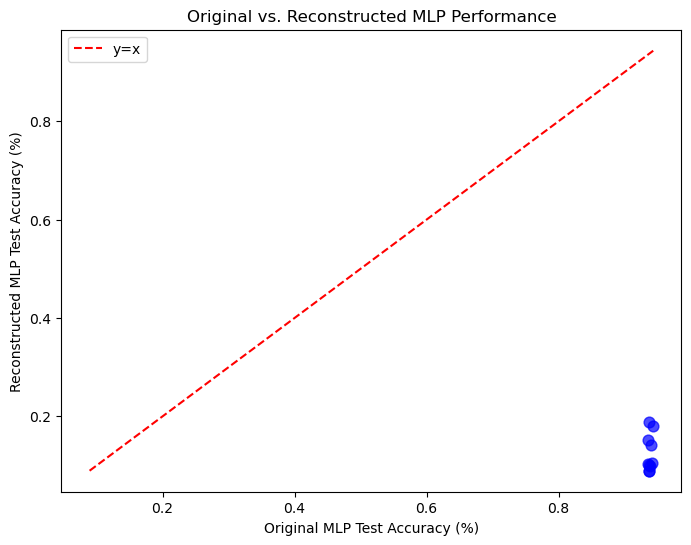

In [29]:
import random
import matplotlib.pyplot as plt

# Number of MLPs to sample
n_samples = 10
indices = random.sample(range(len(dataset)), n_samples)

orig_perfs = []
recon_perfs = []

for idx in indices:
    # Load original MLP weights and build original MLP
    weights, biases = torch.load(dataset.model_paths[idx], weights_only=True)
    original_mlp = load_mlp_from_weights(weights, biases)
    original_mlp.to(device)
    orig_acc = test_mlp(original_mlp, device, test_loader)
    
    # Get the corresponding graph sample from the dataset
    data = dataset[idx].to(device)
    model.eval()
    with torch.no_grad():
        # Pass through the autoencoder to get reconstructed node features.
        x_recon = model(data.x, data.edge_index)
    
    # Rebuild the MLP from the reconstructed graph sample.
    reconstructed_mlp = rebuild_mlp_from_graph(x_recon.cpu(), dataset.max_feat_dim)
    reconstructed_mlp.to(device)
    recon_acc = test_mlp(reconstructed_mlp, device, test_loader)
    
    orig_perfs.append(orig_acc)
    recon_perfs.append(recon_acc)
    print(f"Sample {idx}: Original Acc = {orig_acc*100:.2f}%, Reconstructed Acc = {recon_acc*100:.2f}%")

# Plotting the results
plt.figure(figsize=(8,6))
plt.scatter(orig_perfs, recon_perfs, c='blue', s=60, alpha=0.7)
plt.xlabel("Original MLP Test Accuracy (%)")
plt.ylabel("Reconstructed MLP Test Accuracy (%)")
plt.title("Original vs. Reconstructed MLP Performance")
# Plot a y=x line for reference
min_acc = min(min(orig_perfs), min(recon_perfs))
max_acc = max(max(orig_perfs), max(recon_perfs))
plt.plot([min_acc, max_acc], [min_acc, max_acc], 'r--', label="y=x")
plt.legend()
plt.savefig(f"Graph Autoencoder Input-Output MLP Performances.png", format="png")
plt.show()
